This notebook organizes all the results in the "analysis" folder within a concrete storyline

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

In [2]:
%load_ext autoreload
%autoreload 1
%aimport utils_read_parsing
from utils_timeline_viz import *
from utils_read_parsing import *
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.stats import mannwhitneyu
import seaborn as sns
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 7, 4
pd.set_option('precision',3)
np.set_printoptions(precision=3,suppress=True)

# Preparing the data
We wish to have a table that looks like:

In [13]:
t = [['student','variable','pre','post','index','sim','CVS table','CVS graph']]
t.append(['s1','v1','1.0','2.333','1','B','Yes','No'])
t.append(['s1','v2','...','...','1','B','Yes','Yes'])
t.append(['s1','v3','...','...','2','C','No','No'])
t.append(['s1','v4','...','...','2','C','Yes','No'])
print tabulate(t)


-------  --------  ---  -----  -----  ---  ---------  ---------
student  variable  pre  post   index  sim  CVS table  CVS graph
s1       v1        1.0  2.333  1      B    Yes        No
s1       v2        ...  ...    1      B    Yes        Yes
s1       v3        ...  ...    2      C    No         No
s1       v4        ...  ...    2      C    Yes        No
-------  --------  ---  -----  -----  ---  ---------  ---------


## Grabing the CVS data...

In [3]:
# pre_df = pd.read_csv('pre_survey_results.txt', sep='\t')
table_cvs_df = pd.read_csv('table_cvs_results.txt', sep='\t')
graph_cvs_df = pd.read_csv('graph_cvs_results.txt', sep='\t')

In [4]:
metadf = get_student_metadata()
order = dict(zip(metadf.index,metadf['activity order']))
graph_cvs_df['activity order'] = graph_cvs_df.studentid.apply(lambda sid: order[sid])
table_cvs_df['activity order'] = table_cvs_df.studentid.apply(lambda sid: order[sid])

In [5]:
variables = ["Battery voltage","Area","Separation","Wavelength","Width","Concentration"]

def binarize(number):
    if number>0 : return 1
    else: return 0

graph_cvs_df2 = graph_cvs_df.copy()
for v in variables:
    graph_cvs_df2[v] = graph_cvs_df.apply(lambda row: binarize(row[v]), axis=1)

table_cvs_df2 = table_cvs_df.copy()
for v in variables:
    table_cvs_df2[v] = table_cvs_df.apply(lambda row: binarize(row[v]), axis=1)

graph_cvs_df2['sum'] = graph_cvs_df2[variables].sum(axis=1)
table_cvs_df2['sum'] = table_cvs_df2[variables].sum(axis=1)
table_cvs_df2['sum caps'] = table_cvs_df2[['Battery voltage','Area','Separation']].sum(axis=1)
table_cvs_df2['sum light absorbance'] = table_cvs_df2[["Wavelength","Width","Concentration"]].sum(axis=1)
graph_cvs_df2['sum caps'] = graph_cvs_df2[['Battery voltage','Area','Separation']].sum(axis=1)
graph_cvs_df2['sum light absorbance'] = graph_cvs_df2[["Wavelength","Width","Concentration"]].sum(axis=1)
table_cvs_df2.head()

,studentid,Battery voltage,Area,Separation,Wavelength,Width,Concentration,activity order,sum,sum caps,sum light absorbance
0,11612162,0,0,0,1,1,1,CL,3,0,3
1,13660166,0,0,0,0,0,1,LC,1,0,1
2,41947147,1,0,0,1,1,1,CL,4,1,3
3,64006159,0,0,0,1,0,1,LC,2,0,2
4,15749160,0,1,1,0,1,1,CL,4,2,2


## Grabbing the worksheet data

In [46]:
%reload_ext utils_read_parsing
worksheets = get_worksheet_metadata('beers')
pre = get_pre_worksheet(sim='beers')
main = get_main_worksheet(sim='beers')

ids = get_students_to_analyze_log_worksheets('beers')
pre= pre[pre['Student ID'].isin(worksheets[(worksheets['Type']=='p')&worksheets['Student ID'].isin(ids)]['other id'].values)]
main= main[main['Student ID'].isin(worksheets[(worksheets['Type']=='m')&worksheets['Student ID'].isin(ids)]['other id'].values)]
print len(ids),len(pre),len(main)

135 135 135


In [47]:
pre['id in logs'] = pre['Student ID'].apply(lambda row: worksheets.loc[worksheets[worksheets['other id']==row].index[0],'Student ID'])
main['id in logs'] = main['Student ID'].apply(lambda row: worksheets.loc[worksheets[worksheets['other id']==row].index[0],'Student ID'])

In [90]:
pre.head()

,Student ID,Concentration,Wavelength,Width,id in logs
0,10127163,1.0,1.0,1.0,10127163
1,10232160,1.0,1.0,1.0,10232160
2,10375160,1.0,1.0,0.0,10537160
3,10375163,0.0,1.0,1.0,10375163
4,10420167,1.0,1.0,0.0,10420167


In [91]:
melted_pre = pd.melt(pre, id_vars=['id in logs'], value_vars=['Concentration','Wavelength','Width'], var_name='variable',value_name='pre')
melted_main = pd.melt(main, id_vars=['id in logs'], value_vars=['Concentration','Wavelength','Width'], var_name='variable',value_name='main')

In [92]:
scores = melted_pre.merge(melted_main, on=['id in logs','variable'], how='outer')
scores['sim'] = 'L'

In [93]:
scores['CVS_table'] = scores.apply(lambda row: table_cvs_df2.loc[table_cvs_df2[table_cvs_df2['studentid']==row['id in logs']].index[0],row['variable']],axis=1)
scores['CVS_graph'] = scores.apply(lambda row: graph_cvs_df2.loc[graph_cvs_df2[graph_cvs_df2['studentid']==row['id in logs']].index[0],row['variable']],axis=1)

In [102]:
scores['index'] = scores.apply(lambda row: table_cvs_df2.loc[table_cvs_df2[table_cvs_df2['studentid']==row['id in logs']].index[0],'activity order'].index(row['sim'])+1,axis=1)

In [103]:
scores.sort_values('id in logs').head()

,id in logs,variable,pre,main,sim,CVS_table,CVS_graph,index
0,10127163,Concentration,1.0,3.0,L,1,1,1
270,10127163,Width,1.0,3.0,L,1,1,1
135,10127163,Wavelength,1.0,1.0,L,1,1,1
97,10192168,Concentration,1.0,3.0,L,1,1,2
367,10192168,Width,1.0,0.0,L,1,0,2


# Preliminary results
** \*\*\*\*NOTE:** Currently all results are for beers data since that's what we have activity coding data for. \*\*\*\*

## Student simulation experience
Are students used to using simulations and have they covered either topic before?

## Learning in the PhET
Let's look at pre to post to see if students learn

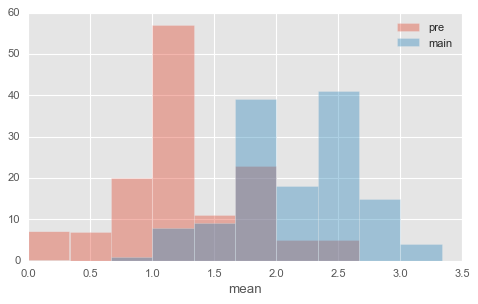

In [9]:
bins = [0,0.333,0.666, 1.0, 1.333, 1.666, 2.0, 2.333, 2.666, 3.0, 3.333]
sns.distplot(pre['mean'],bins=bins,kde=False,label='pre')
ax = sns.distplot(main['mean'],bins=bins,kde=False,label='main')
ax.legend()

In [10]:
pre.sort_values('Student ID')
main.sort_values('Student ID')
set(pre['Student ID'])==set(main['Student ID'])

False

Post activity model of sim doesn’t depend on incoming knowledge. This results suggests that the use of inquiry strategies is what determines leaning/model quality

# How can inquiry strategies be detected through log data in a PhET sim activity?

## Detect two behaviors, or potential strategies: collection of CVS in table and the plotting of CVS data in a graph
How often is CVS used per variable?

Quantitative variables are similar, so let's concentrate on those.

## Motivation for splitting into two behaviors
Let's compare the two strategies in terms of sampling

## Relation between behavior and pre score

Use of strategy doesn’t depend on pre

## Relation between behavior and pre score

Yes use of strategies changes outcome! Suggesting that the captured behaviors are deliberate inquiry strategies employed by students

# How does using strategy help student learn?

## Sequential or not

## Number of points used

## Consistency by sim 

# How does the use of inquiry strategies change over time? Do students change their inquiry strategies over time and if so for the better of their post scores?

## Consistency over time: proficient users of strategy are consistent, less proficient are less consistent

## Order increases use of strategy and order increases post score

## Use of CVS in table vs. graph over time